# Listings Room Descriptors and Charges
Exploring different things _about the rental_ in the listings table.




In [46]:
%matplotlib inline

In [47]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import duckdb
from pandas.api.types import is_numeric_dtype

sns.set(style="whitegrid")

THEME = "darkslategray"


In [48]:
print(duckdb.__version__)

0.5.1


In [49]:
import warnings
warnings.filterwarnings('ignore')

## Connect/create duckDB file

In [50]:
con = duckdb.connect(database='PS6.duckdb', read_only=True)


## Add Data
Reference: https://duckdb.org/docs/api/python/overview

# Room descriptors
The following room descriptors give information about the rental property. How many rooms, bathrooms, and beds does it have? How many people can it accomodate? All things being equal, the more of these will mean a higher price to rent. 

* property_type - text
* room_type - text - currently in shared listings
* accomodates - integer
* bathrooms - text  (problem-- this is showing up as blanks)
* bathrooms_text - text
* bedrooms - integer
* beds- integer
* amenities - list in []- This could be expanded to individual columns


Target Variable
* price


For the following exploration, we will use the latest_listings table, which includes only one of each listing, taking the most recent data if there were duplicates in the data set.

# Single Variable EDA
First, we'll start with an investigation of AirBnB price... copy/paste tanner's EDA here

In [51]:
con.execute("select property_type, room_type, accommodates, bathrooms, bathrooms_text, bedrooms, beds, amenities, price from latest_listings;")
listings = con.fetchall()

In [52]:
room_columns = ['property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price']
listings_df = pd.DataFrame(listings, columns=room_columns)
listings_df.head()

,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price
0,Private room in home,Private room,1,None,1 private bath,1.0,1.0,"[""Dryer"", ""Smoke alarm"", ""Cooking basics"", ""In...",67.0
1,Private room in rental unit,Private room,1,None,2 shared baths,1.0,1.0,"[""Smoke alarm"", ""Cooking basics"", ""Bed linens""...",39.0
2,Private room in townhouse,Private room,3,None,1 private bath,1.0,2.0,"[""Dryer"", ""Smoke alarm"", ""Single level home"", ...",75.0
3,Entire condo,Entire home/apt,2,None,1.5 baths,1.0,1.0,"[""Dryer"", ""TV with standard cable"", ""Cooking b...",250.0
4,Private room in condo,Private room,1,None,3 shared baths,1.0,1.0,"[""Smoke alarm"", ""Cooking basics"", ""Bed linens""...",35.0


<a id="price"></a> 
## Price

In [53]:
listings_df["price"].describe()

count    10560.000000
mean       198.181818
std        422.463628
min          0.000000
25%         85.000000
50%        129.000000
75%        206.000000
max      24999.000000
Name: price, dtype: float64

In [54]:
from tabulate import tabulate

In [55]:
con.execute("SELECT DISTINCT id, name, price from all_listings WHERE price < 5")
low_cost = list(con.fetchall())
print(tabulate(low_cost, headers=["id", "name", "price"], tablefmt='fancy_grid'))

╒══════════╤════════════════════════════════╤═════════╕
│       id │ name                           │   price │
╞══════════╪════════════════════════════════╪═════════╡
│ 42738808 │ Capital View Hostel            │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43036130 │ U Street Capsule Hostel        │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 46253554 │ citizenM Washington DC Capitol │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43301430 │ Riggs Washington DC            │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 42065771 │ The LINE Hotel DC              │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43308773 │ Viceroy Washington DC          │       0 │
╘══════════╧════════════════════════════════╧═════════╛


In [56]:
con.execute("SELECT DISTINCT id, name, price from all_listings WHERE price > 5000")
low_cost = list(con.fetchall())
print(tabulate(low_cost, headers=["id", "name", "price"], tablefmt='fancy_grid'))

╒════════════════════╤════════════════════════════════════════════════════╤═════════╕
│                 id │ name                                               │   price │
╞════════════════════╪════════════════════════════════════════════════════╪═════════╡
│           14507861 │ Entire Capitol Hill Home - 5BR/4BA                 │    5995 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│           46004444 │ Yours Truly DC, 2 Bedroom Master Suite             │   10000 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│ 614471937104927680 │ NEW Listing! Unique House+Garden Rental, sleeps 40 │    7500 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│            8303678 │ Vista 2 Bedroom Rowhome FoggyBottom                │    6000 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│            8784458 │ Spacious condo in NW, DC       

In [57]:
## Code taken from Lab 5 solution
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freeman Diaconis:  11


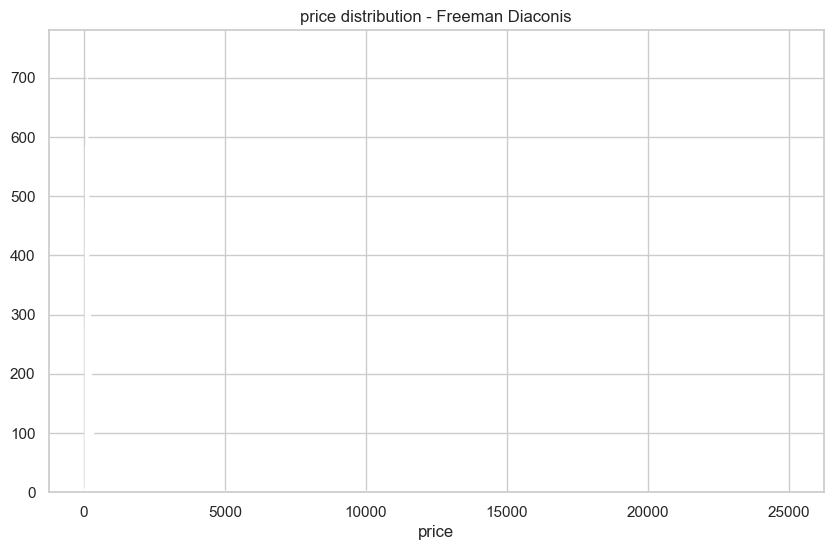

In [58]:
h = freeman_diaconis(listings_df.price)
plot_data = listings_df.price
variable_name = "price"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

In [59]:
trimmed_listings = listings_df[listings_df.price < 1500]

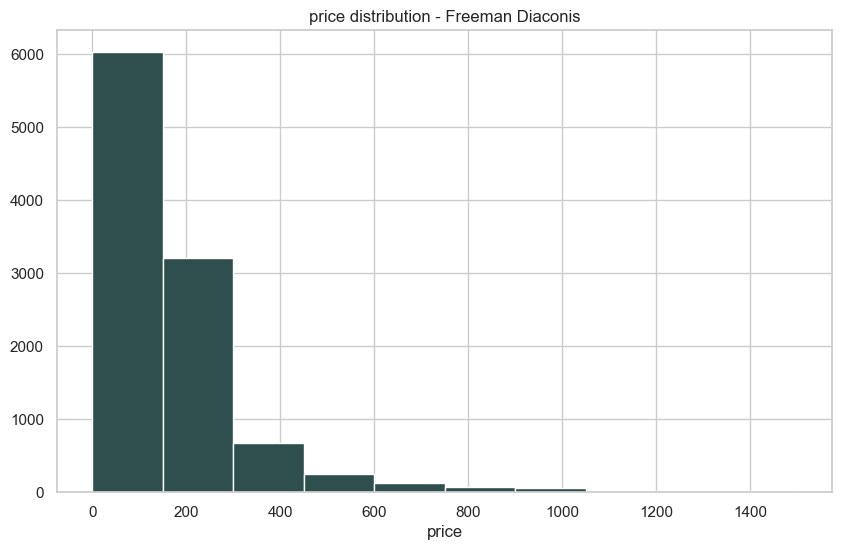

In [60]:
plot_data = trimmed_listings.price

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

In [61]:
# not needed
#listings_df['price'] = listings_df['price'].replace('[\$\,]', '', regex=True).astype(float)
#listings_df['price'].head()

_Use Tanner's descriptions here_


We should also limit price to those over 0


In [115]:
trimmed_listings = listings_df[listings_df.price > 0]

## Property_Type

First, we'll look at what this column describes.


Queries:
* select distinct room_type, property_type from listings order by room_type;  
* select count(property_type), property_type from listings group by property_type;  
* select distinct property_type from listings;  


In [63]:
listings_df.property_type.describe()

count                  10560
unique                    61
top       Entire rental unit
freq                    3488
Name: property_type, dtype: object

There are 61 distinct values for this column, with the most frequent item being "Entire rental unit."

Next, we'll look at the distribution of each category. Since there are 61 of these, we'll rely on a table to parse the info.

In [82]:
con.execute("select property_type, count(property_type) as prop_count from latest_listings group by property_type order by prop_count desc;")
distinct_property_types = con.fetchall()
print(tabulate(distinct_property_types, headers=['Property Type', 'Count'], tablefmt='fancy_grid'))

╒═════════════════════════════════════╤═════════╕
│ Property Type                       │   Count │
╞═════════════════════════════════════╪═════════╡
│ Entire rental unit                  │    3488 │
├─────────────────────────────────────┼─────────┤
│ Entire serviced apartment           │     889 │
├─────────────────────────────────────┼─────────┤
│ Entire townhouse                    │     811 │
├─────────────────────────────────────┼─────────┤
│ Entire home                         │     739 │
├─────────────────────────────────────┼─────────┤
│ Entire guest suite                  │     632 │
├─────────────────────────────────────┼─────────┤
│ Private room in home                │     606 │
├─────────────────────────────────────┼─────────┤
│ Entire condo                        │     595 │
├─────────────────────────────────────┼─────────┤
│ Private room in townhouse           │     522 │
├─────────────────────────────────────┼─────────┤
│ Private room in rental unit         │     449 │


The most frequent property types include "entire" in the description, initially indicating that you would have the unit to yourself.

This is a category for the listing that indicates:
1) Is this an apartment, condo, townhome, house, guesthouse, vacation home, etc?
2) Which part of category 1 does the renter get to themselves?

It should be separated into two descriptors if possible. Part 2 is covered by Room_Type below.


## Room_Type
The property type above seemed to include the "Room type". We'll see what it actually means:


In [64]:
con.execute("select distinct room_type from latest_listings;")
distrinct_room_types = con.fetchall()
distrinct_room_types

[('Private room',), ('Entire home/apt',), ('Shared room',), ('Hotel room',)]

This is a nice categorical in that there are few options:
* Entire home/apt
* Private room
* Shared room
* Hotel room

This covers part 2 of the "property type" above. 

Let's see the relationship between property_type and room_type

In [100]:
con.execute("select distinct room_type, property_type, count(property_type) as counts from latest_listings group by room_type, property_type order by room_type, counts desc;")
roomtype_proptype_counts = con.fetchall()
roomtype_proptype_counts_df = pd.DataFrame(roomtype_proptype_counts, columns=['room_type', 'property_type', 'property_type_counts'])

print(tabulate(roomtype_proptype_counts, headers=['room_type', 'property_type', 'counts'], tablefmt='pretty'))

+-----------------+-------------------------------------+--------+
|    room_type    |            property_type            | counts |
+-----------------+-------------------------------------+--------+
| Entire home/apt |         Entire rental unit          |  3488  |
| Entire home/apt |      Entire serviced apartment      |  889   |
| Entire home/apt |          Entire townhouse           |  811   |
| Entire home/apt |             Entire home             |  739   |
| Entire home/apt |         Entire guest suite          |  632   |
| Entire home/apt |            Entire condo             |  595   |
| Entire home/apt |       Entire residential home       |  307   |
| Entire home/apt |     Entire condominium (condo)      |  300   |
| Entire home/apt |          Entire guesthouse          |   83   |
| Entire home/apt |             Entire loft             |   51   |
| Entire home/apt |        Entire vacation home         |   17   |
| Entire home/apt |         Room in aparthotel          |   16

Each of the property types maps to a room type, and it looks like most of the listings in the Washington DC area are for Entire homes/apartments.

We'll plot the counts for each of these four types below:

Entire home/apt    7975
Private room       2399
Shared room         158
Hotel room           28
Name: room_type, dtype: int64


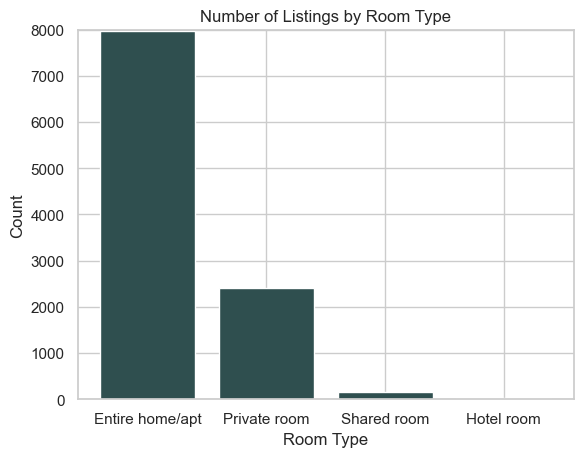

In [102]:
room_type_list = listings_df['room_type'].unique()
room_type_list

room_type_count = listings_df['room_type'].sort_index().value_counts()
print(room_type_count)

figure = plt.figure()
ax1 = figure.add_subplot(1,1,1)
ax1.bar(room_type_count.index, room_type_count, color=THEME)
ax1.set_xlabel("Room Type")
ax1.set_ylabel("Count")
ax1.set_title("Number of Listings by Room Type")
ax1.set_ylim(0,8000)
ax1.yaxis.grid( visible=True, which="major")
ax1.set_axisbelow(True)


Of the ~10,500 listings, almost 8000 were 'Entire home/apt', followed by 'Private room', then very few for 'Shared room' and 'Hotel room'.

## Accomodates

This describes the maximum capacity for the unit.

First, we'll look at the distribution.


+-------------+-----------------+
| Accomodates | Num of Listings |
+-------------+-----------------+
|      0      |        5        |
|      1      |      1007       |
|      2      |      3319       |
|      3      |      1487       |
|      4      |      2262       |
|      5      |       721       |
|      6      |       899       |
|      7      |       163       |
|      8      |       348       |
|      9      |       39        |
|     10      |       129       |
|     11      |       16        |
|     12      |       81        |
|     13      |       12        |
|     14      |       16        |
|     15      |        7        |
|     16      |       49        |
+-------------+-----------------+


Text(0.5, 1.0, 'Accomodates distribution')

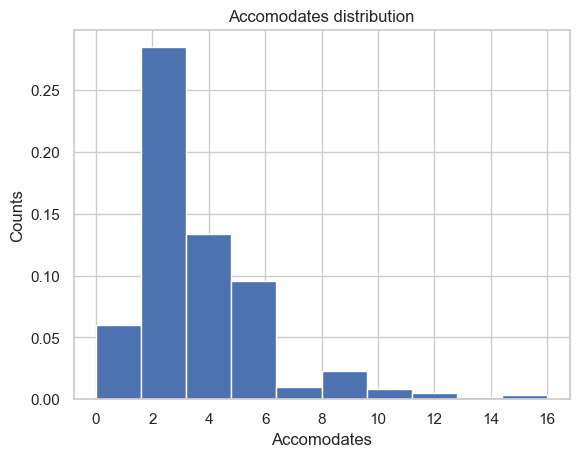

In [124]:
accommodates_count = listings_df['accommodates'].value_counts().sort_index()
accommodates_count = pd.DataFrame(accommodates_count)
print(tabulate(accommodates_count, headers=['Accomodates', 'Num of Listings'], tablefmt='pretty'))


figure = plt.figure()
ax1 = figure.add_subplot(1,1,1)
ax1.hist(listings_df['accommodates'],density=True)
ax1.set_xlabel('Accomodates')
ax1.set_ylabel('Counts')
ax1.set_title('Accomodates distribution')

More than a quarter of the listings are from the two to four range. There's an oddity where the a property accommodates 0.

In [117]:
listings_df[listings_df.accommodates == 0]

,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price
3151,Room in hostel,Hotel room,0,None,None,NaN,NaN,"[""Long term stays allowed"", ""Smoke alarm"", ""Fi...",0.0
3275,Room in hostel,Hotel room,0,None,None,NaN,NaN,"[""Long term stays allowed"", ""Dryer"", ""Luggage ...",0.0
3592,Room in boutique hotel,Hotel room,0,None,None,NaN,NaN,"[""43\"" HDTV with Chromecast"", ""Long term stays...",0.0
6650,Room in boutique hotel,Hotel room,0,None,None,NaN,NaN,"[""Cooked-to-order breakfast available \u2014 $...",0.0
9909,Room in boutique hotel,Hotel room,0,None,None,NaN,NaN,"[""Heating"", ""Concierge"", ""Toiletries"", ""Fire e...",0.0


Looking at these listings, if accommodates is zero, there is no further information about the listing- The number of bathrooms, bedrooms, and beds are all blank, and the price is 0. This is unreliable, and cannot be used in prediction.

This condition can be used to filter out data that cannot be used in a model.

## Bathrooms 

This is a text type variable.

__Problem__ This data shows up as blank in the source CSV data, so it will show up as a blank in our data warehouse.  

We may need to use the bathrooms_text to pull out this info.



## bathrooms_text

This includes
1. how many baths (counting half baths) are available to the renter
2. if the baths are 'shared' or not 

Both of these need to be pulled out in order for this to be of use.


In [73]:
listings_df.bathrooms_text.unique()

array(['1 private bath', '2 shared baths', '1.5 baths', '3 shared baths',
       '1 shared bath', '1 bath', '2.5 baths', None, '1.5 shared baths',
       '2 baths', '4 baths', '3.5 baths', '4.5 baths', '2.5 shared baths',
       '8 shared baths', '6 baths', '3 baths', '5 baths', '0 baths',
       '0 shared baths', '7 baths', '5.5 baths', '5.5 shared baths',
       '4.5 shared baths', '3.5 shared baths', 'Half-bath',
       '5 shared baths', '15 baths', '4 shared baths', '6 shared baths',
       'Shared half-bath', '7.5 baths', 'Private half-bath',
       '11 shared baths', '11 baths', '6.5 baths', '50 shared baths'],
      dtype=object)

## Bedrooms
This is the number of bedrooms available to the renter, and is a numerical value.


+----------+-----------------+
| Bedrooms | Num of Listings |
+----------+-----------------+
|   1.0    |      6225       |
|   2.0    |      2089       |
|   3.0    |       822       |
|   4.0    |       324       |
|   5.0    |       90        |
|   6.0    |       34        |
|   7.0    |       10        |
|   8.0    |        1        |
|   9.0    |        3        |
|   11.0   |        1        |
|   15.0   |        1        |
+----------+-----------------+


Text(0.5, 1.0, 'Bedrooms distribution')

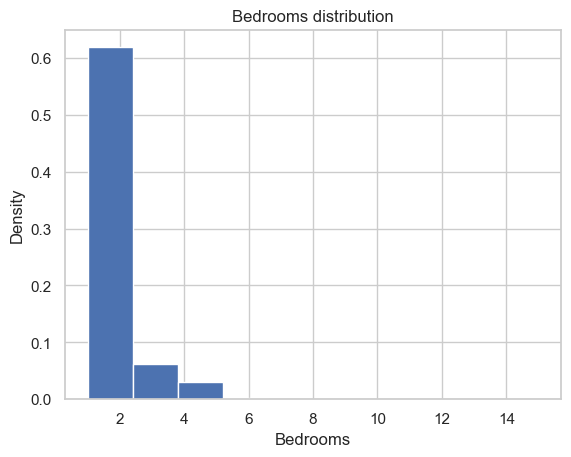

In [126]:
item_count = listings_df['bedrooms'].value_counts().sort_index()
item_count = pd.DataFrame(item_count)
print(tabulate(item_count, headers=['Bedrooms', 'Num of Listings'], tablefmt='pretty'))

figure = plt.figure()
ax1 = figure.add_subplot(1,1,1)
ax1.hist(listings_df['bedrooms'],density=True)
ax1.set_xlabel('Bedrooms')
ax1.set_ylabel('Density')
ax1.set_title('Bedrooms distribution')

Roughly 80% of the listings are for 1-2 bedrooms.

## Amenities
This is a list of text items in a column, and could be expanded into individual columns with additional time.

The items seem fairly consistent.

In [78]:
listings_df.amenities.head()

0    ["Dryer", "Smoke alarm", "Cooking basics", "In...
1    ["Smoke alarm", "Cooking basics", "Bed linens"...
2    ["Dryer", "Smoke alarm", "Single level home", ...
3    ["Dryer", "TV with standard cable", "Cooking b...
4    ["Smoke alarm", "Cooking basics", "Bed linens"...
Name: amenities, dtype: object

# Pairwise EDA
In this section, we'll look at the relationship between the room descriptors and the target variable, price.

## Room Type v. Price

We expect an "entire home/apt" to price higher than a "private" room or "hotel room", which would price higher than a "shared room."


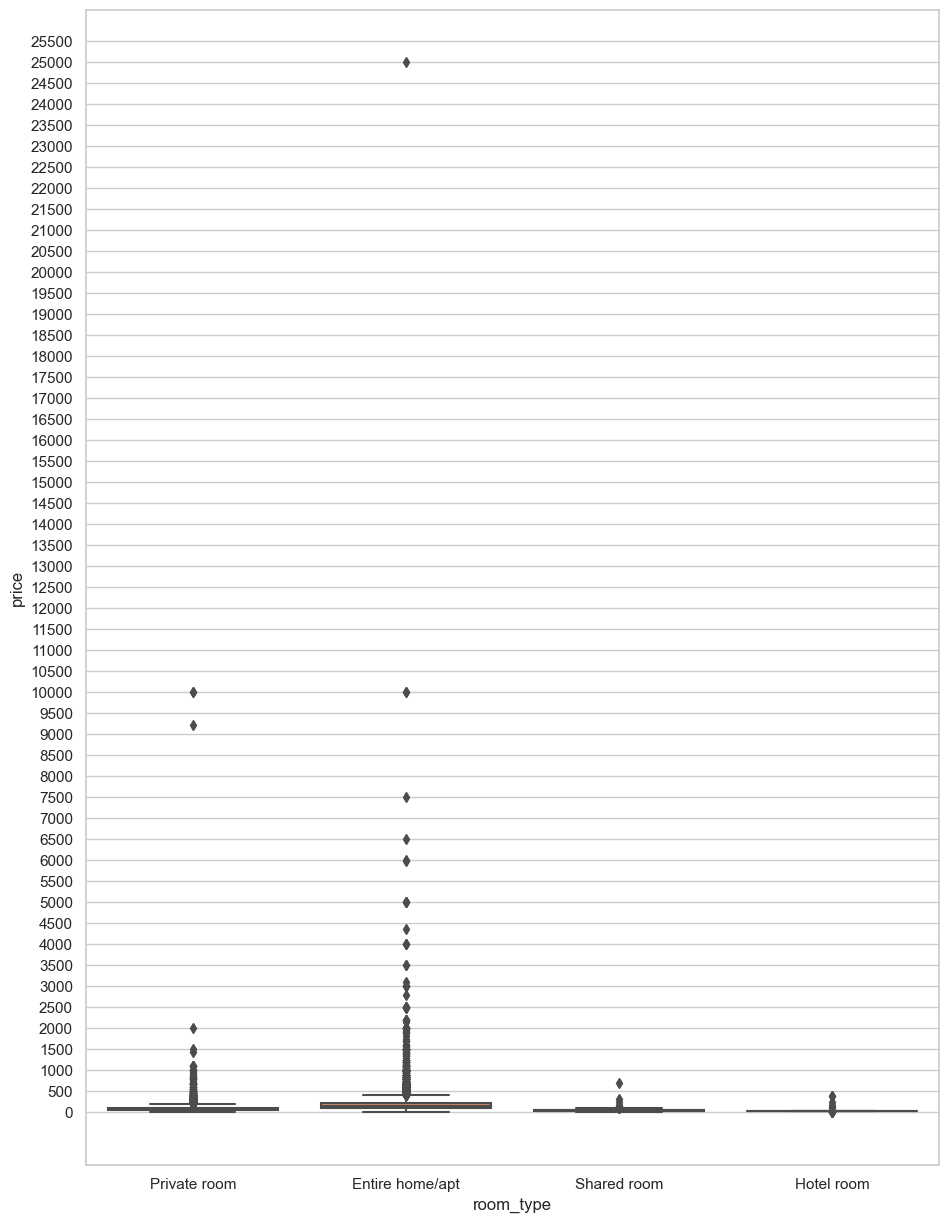

In [103]:
max_plot_price = 26000
fig = plt.figure(figsize=(11,15))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(x = 'room_type', y='price', data = listings_df)
ax1.set_yticks(range(0,max_plot_price,500))
plt.show()

The extreme values, especially the $25,000 listing, makes it hard to see the distribution of prices per room type.

These extreme values are real prices, and I am hesitant to throw them out.

We'll zoom into the majority of data points below.

In [137]:

def plot_box_cat(plot_df, x_name, y_name, y_lim, y_step):
    fig = plt.figure(figsize=(9,12))
    ax1 = fig.add_subplot(1,1,1)
    sns.boxplot(x = x_name, y=y_name, data = plot_df)
    ax1.set_yticks(range(0,y_lim,y_step))
    ax1.set(ylim=[0,y_lim])
    plt.show()

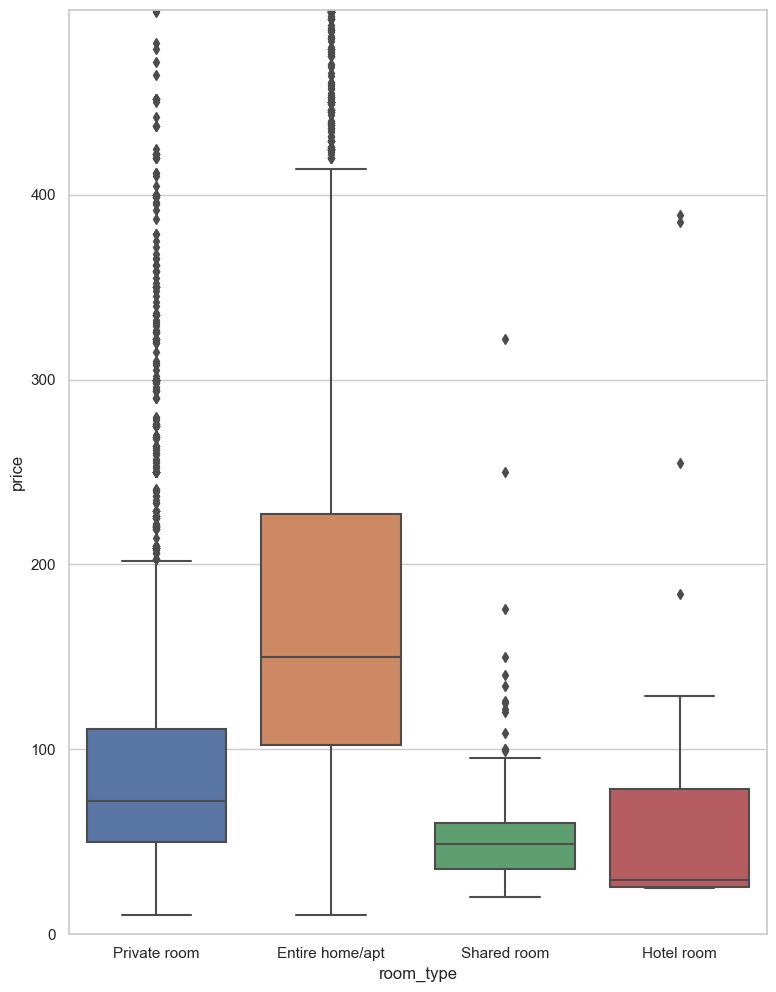

In [135]:
max_plot_price = 500
#plot_df = listings_df[listings_df.price < max_plot_price]
plot_df = listings_df[listings_df.price > 0]
plot_box_cat(plot_df, 'room_type', 'price', max_plot_price, 100)



As expected, the Entire home/apt is the most pricey. This is followed by private room. The shared room median is above the hotel room median. I expected the hotel room to follow the private room trend, but it did not. With 28 of the total ~10,500 listings being hotel rooms, there may be some issues here. _todo explain_

## Accomodates

We expect the price to increase as the maximum accomodation for a listing increases.

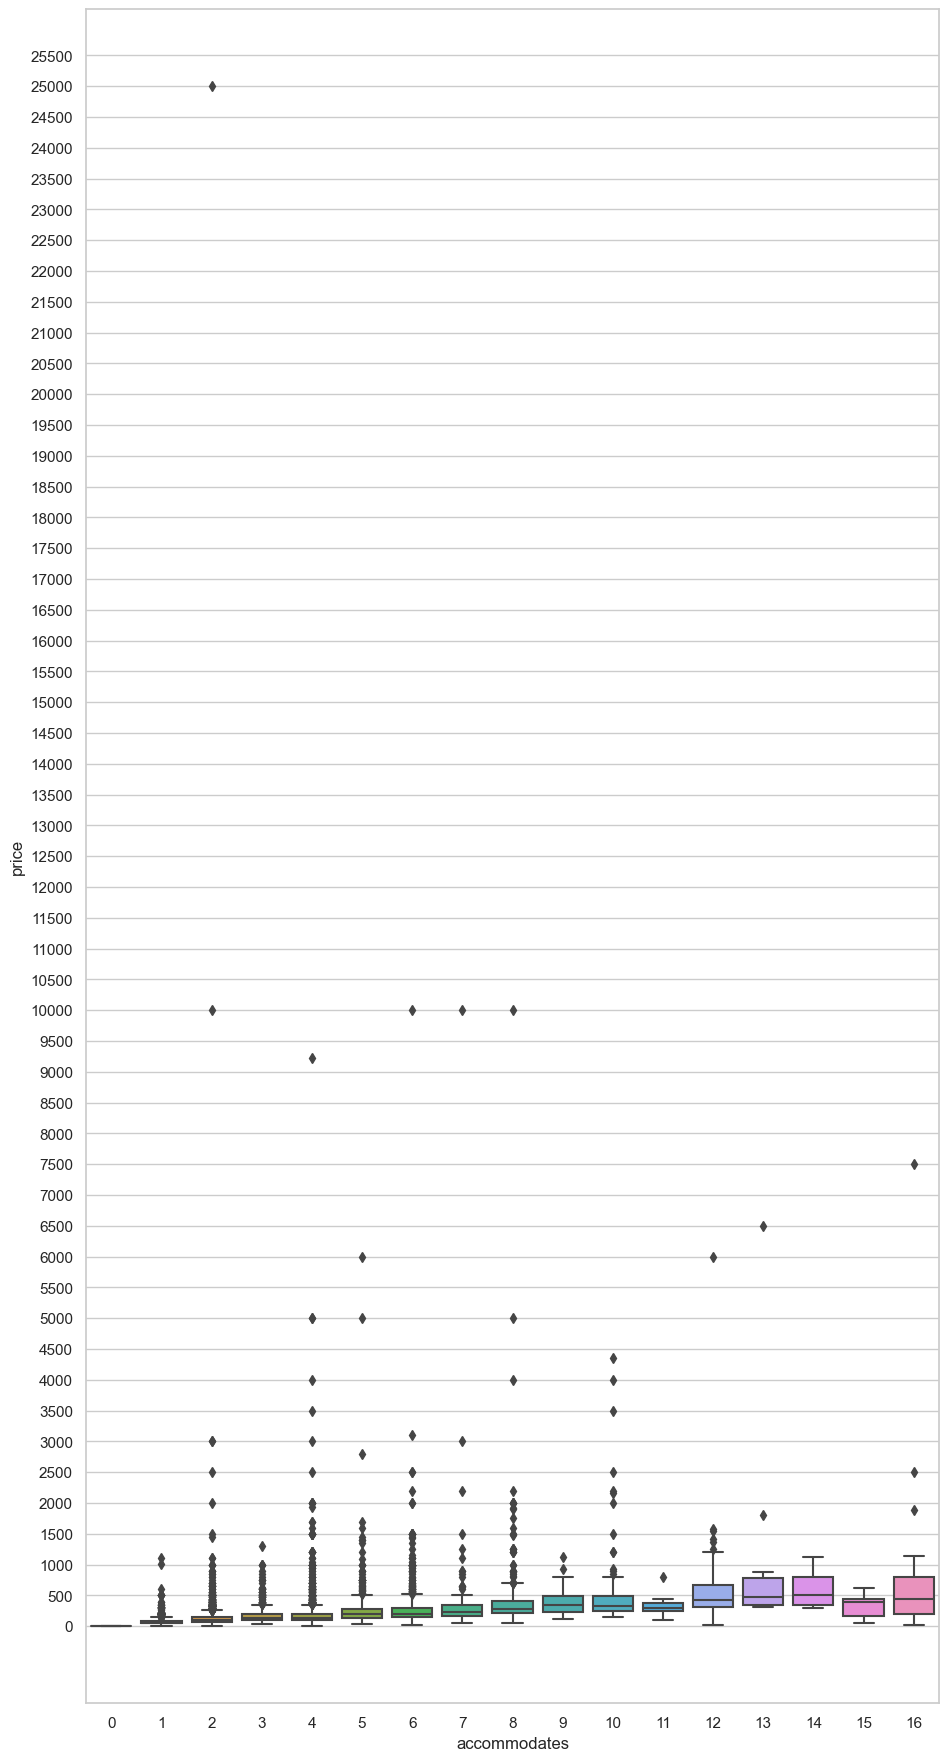

In [118]:
fig = plt.figure(figsize=(11,22))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(x = 'accommodates', y='price', data = listings_df)
ax1.set_yticks(range(0,26000,500))
plt.show()

Once again, the extreme values make it difficult to see the majority of the distributions. We'll limit the view in the next plot:

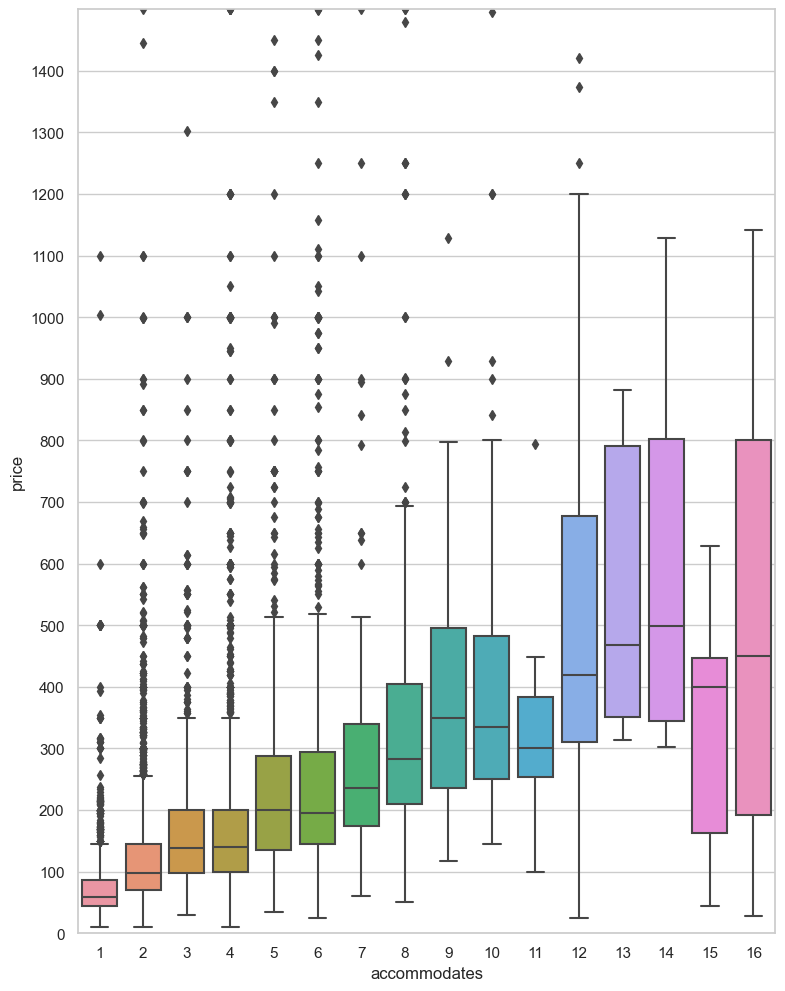

In [138]:
max_plot_price = 1500
#plot_df = listings_df[listings_df.price < max_plot_price]
plot_df = listings_df[listings_df.price > 0]
plot_box_cat(plot_df, 'accommodates', 'price', max_plot_price, 100)


The mean price tends to increase as the maximum accommodations increase. There is a wider distribution of prices as maximum accomodations increases as well. 

There may be another variable that can explain the distribution.

## Bedrooms
As with accomodations, we expect the price to increase as the number of bedrooms increases.

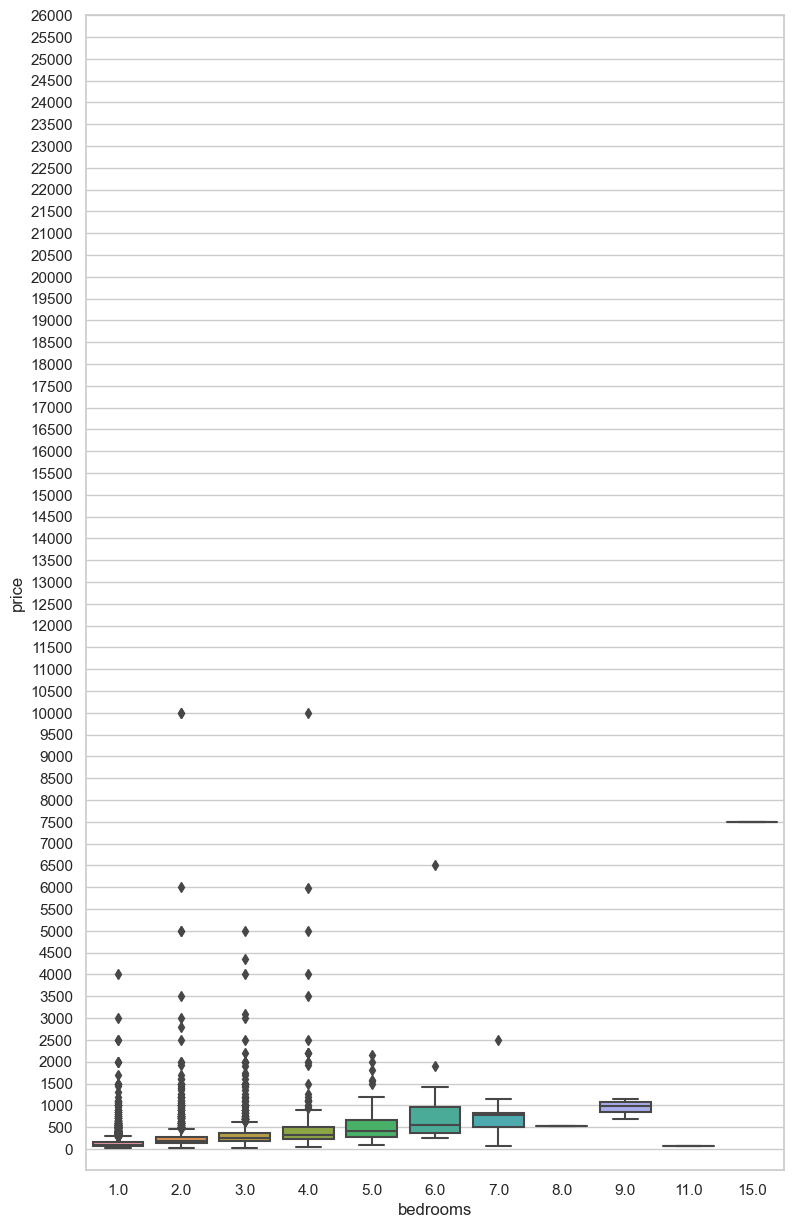

In [139]:
fig = plt.figure(figsize=(9,15))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(x = 'bedrooms', y='price', data = listings_df)
ax1.set_yticks(range(0,26500,500))
plt.show()

We can generally see an increase in the overall distribution of prices as we go up in bedrooms until about 8 bedrooms. There are more outliers from 1-4 bedrooms.

It's hard to see the majority if the distributions, so we'll zoom in:

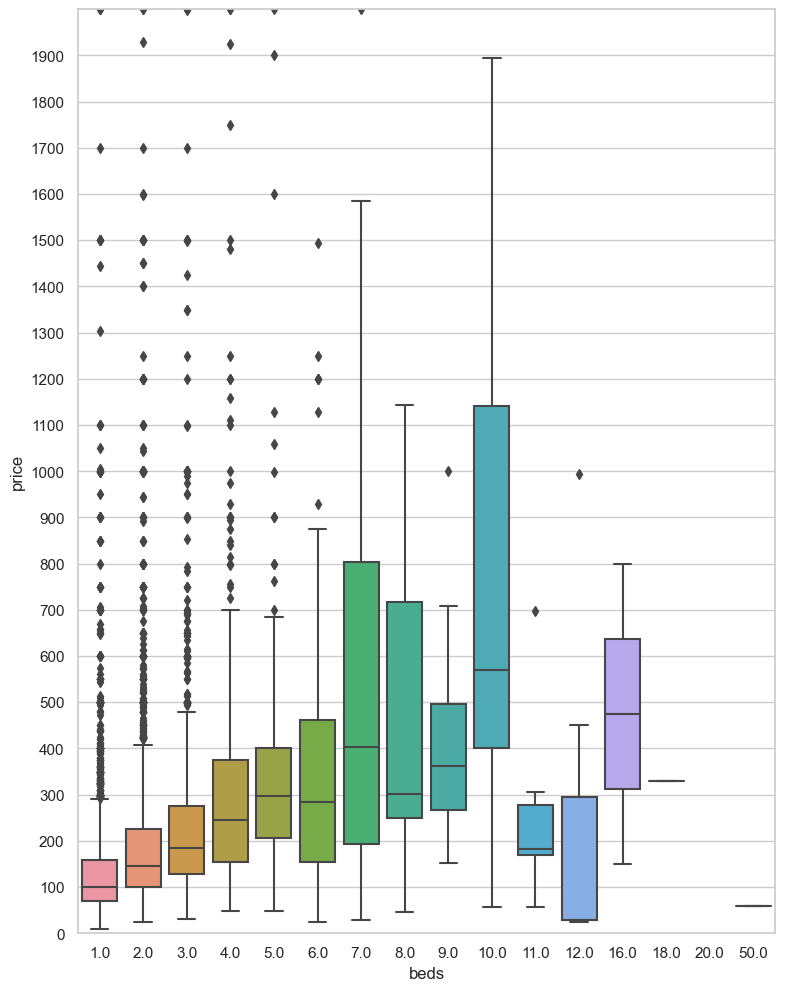

In [140]:
max_plot_price = 2000
#plot_df = listings_df[listings_df.price < max_plot_price]
plot_df = listings_df[listings_df.price > 0]
plot_box_cat(plot_df, 'beds', 'price', max_plot_price, 100)


Rising averages and rising distributions as x increases.

# Exploration Conclusion

## Room descriptors
* property_type 
* room_type - whole house > room > shared
* accomodates ->+ price
* bathrooms ->+ price  (actuals TBD)
* bedrooms ->+ price
* beds->+ price
* amenities (TBD)  

  
The numeric values are all related: accommodates, bathrooms, bedrooms, beds. The more people you can fit in, the higher the price is generally. The function criteria for "accommodates" isn't listed, but it should be a function of the number of bedrooms and bathrooms. Overall, as these increase, so does price.  

## Filters
There were a number of rows that should be thrown away as errors because they cannot be true, and we have no way to correct them in the data. For the following criteria, we will drop the data:
* Price is 0
* Accommodates is 0


## To do if additional time:
* extract bathrooms info
* "private v. shared?"
* extract amenities info

## Questions
1. What accounts for the extreme values?
2. 



## Close the connection
The duckdb file is locked until now... You'll have to close it to run CLI commands.

In [79]:
#con.close()

## Export this notebook to html

In [80]:
import os

os.system('jupyter nbconvert --to html Listings_Room_Descriptors.ipynb')

[NbConvertApp] Converting notebook Listings_Room_Descriptors.ipynb to html
[NbConvertApp] Writing 1201070 bytes to Listings_Room_Descriptors.html


0

## Other notes
There's a CLI that makes it easier to run regular SQL commands quickly.

.open <filename>

then run regular sql commands